In [21]:
import datetime
import numpy
import ray
import torch
#
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})
import pandas as pd
import torch.nn as nn
import yfinance as yf
#
from sklearn.preprocessing import MinMaxScaler
from ray import train,tune
from torch.autograd import Variable

In [22]:
# load dataset
start_time_all = datetime.datetime(2020, 1, 1).strftime('%Y-%m-%d') # 2020-01-01
end_time_train = datetime.datetime(2020, 9, 30).strftime('%Y-%m-%d') # 2020-09-30
start_time_val = datetime.datetime(2020, 10, 1).strftime('%Y-%m-%d') # 2020-10-01
end_time_all = datetime.datetime(2020, 12, 31).strftime('%Y-%m-%d') # 2020-12-31

# loading Tesla, Inc. (TSLA) stock price data from Yahoo Finance
tsla_price_df = yf.download('TSLA', start=start_time_all, end=end_time_all)
tsla_price_df.index = pd.to_datetime(tsla_price_df.index)
tsla_price_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500
...,...,...,...,...,...,...
2020-12-23,210.733337,217.166672,207.523331,215.326660,215.326660,99519000
2020-12-24,214.330002,222.029999,213.666672,220.589996,220.589996,68596800
2020-12-28,224.836670,227.133331,220.266663,221.229996,221.229996,96835800


In [23]:
# features (High price, Low price, Open price, Close price, Volume)
tsla_price_df = tsla_price_df.dropna()
X = tsla_price_df.iloc[:, tsla_price_df.columns != 'Adj Close']
# response (Adj Close price)
y = tsla_price_df.loc[:, 'Adj Close']

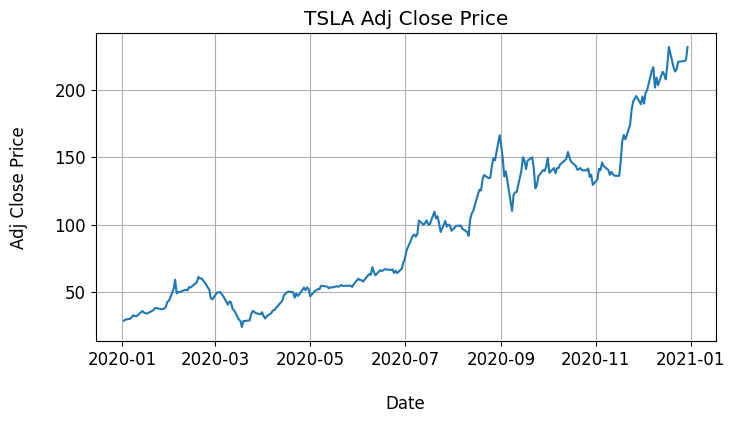

In [24]:
# plotting TSLA Adj Close price from 2020-01-01 to 2020-12-31
plt.plot(y)
plt.xlabel('\nDate')
plt.ylabel('Adj Close Price\n')
plt.title('TSLA Adj Close Price')
plt.show()

In [25]:
# train/test splitting
n_split = 189 # where to split training and validation datasets

# normalizing datasets (this introduces lookahead bias, to be fixed)
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
y_norm = scaler.fit_transform(y.values.reshape(1, -1).reshape(-1, 1))

# training using Jan - Sep data
# validating trained model using Oct - Dec data
X_train = X_norm[:n_split, :]
y_train = y_norm[:n_split, :]

print('Training Set Shape ', X_train.shape, y_train.shape)

Training Set Shape  (189, 5) (189, 1)


In [26]:
# converting data to tensors
X_train_tensors = Variable(torch.Tensor(X_train))
y_train_tensors = Variable(torch.Tensor(y_train))

X_val_tensors = Variable(torch.Tensor(X_norm))
y_true = numpy.array(y).reshape(-1, 1)

# reshaping X dataset
X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 
                                                  1, X_train_tensors.shape[1]))
X_val_tensors = torch.reshape(X_val_tensors, (X_val_tensors.shape[0], 
                                              1, X_val_tensors.shape[1]))

print('Training Set Shape   ', X_train_tensors.shape, y_train_tensors.shape)
print('Validation Set Shape ', X_val_tensors.shape, y_true.shape)

Training Set Shape    torch.Size([189, 1, 5]) torch.Size([189, 1])
Validation Set Shape  torch.Size([252, 1, 5]) (252, 1)


In [27]:
# LSTM
# selecting gpu
device = torch.device('cpu')

In [28]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # number of features
        self.hidden_size = hidden_size # number of features in hidden state
        self.num_layers = num_layers # number of stacked LSTM layers
        self.num_classes = num_classes # number of output classes
    
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

In [29]:
# function for calculating MSE (Mean Squared Error)
def calc_mse(y_true, y_hat):
    mse = float(sum((y_true - y_hat) * (y_true - y_hat)) / len(y_hat))
    return mse

In [30]:
# function for fitting and evaluating model using different hyperparameters
def model_fit_eval(config=None, best_config=None, save_model_state=False):
    if best_config is None:
        hidden_size = config['hidden_size']
        num_layers = config['num_layers']
        learning_rate = config['learning_rate']
        # learning rate controls how much to change model in response to estm error each time model weights are updated
        num_epochs = config['num_epochs']
    else:
        hidden_size = best_config['hidden_size']
        num_layers = best_config['num_layers']
        learning_rate = best_config['learning_rate']
        num_epochs = best_config['num_epochs']

    input_size = len(X.columns)
    num_classes = 1
    
    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    for epoch in range(num_epochs + 1):
        outputs = model.forward(X_train_tensors.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train_tensors.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e. backprop
        if best_config is not None:
            if epoch % 1000 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    
    # saving model state
    if save_model_state:
        torch.save(model.state_dict(), '1-model-state.pth')

    # loading model state
    # model = LSTM_model(*args, **kwargs)
    # model.load_state_dict(torch.load(PATH))
    # model.eval()
    
    # predicting response from model
    y_hat = model(X_val_tensors.to(device)) # forward pass
    y_hat = y_hat.data.detach().cpu().numpy() # numpy conversion
    y_hat = scaler.inverse_transform(y_hat) # inverse transformation

    if best_config is None:
        mse = calc_mse(y_true, y_hat)
        train.report({'mse': mse})
    else:
        return y_hat

In [31]:
# starting ray runtime
ray.init()

2023-10-12 22:05:36,696	INFO worker.py:1642 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.7.1


In [32]:
# checking available resources
ray.cluster_resources()

{'CPU': 8.0,
 'node:127.0.0.1': 1.0,
 'memory': 12241394075.0,
 'object_store_memory': 6120697036.0,
 'node:__internal_head__': 1.0}

In [33]:
# using grid search to get best hyperparameters
analysis = tune.run(
    model_fit_eval, 
    config={'hidden_size': tune.grid_search([2, 3, 5]), 
            'learning_rate': tune.grid_search([0.0005, 0.001, 0.002]), 
            'num_epochs': tune.grid_search([2000, 4000, 8000]), 
            'num_layers': tune.grid_search([1, 2, 4])}, 
    resources_per_trial={'cpu': 2, 'gpu': 0}) # leveraging all resources

2023-10-12 22:05:39,571	INFO tune.py:645 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,mse
model_fit_eval_b717b_00000,765.534
model_fit_eval_b717b_00001,132.067
model_fit_eval_b717b_00002,39.5922
model_fit_eval_b717b_00003,131.627
model_fit_eval_b717b_00004,260.171
model_fit_eval_b717b_00005,39.7358
model_fit_eval_b717b_00006,61.9557
model_fit_eval_b717b_00007,47.0067
model_fit_eval_b717b_00008,23.1858
model_fit_eval_b717b_00009,95.6268


2023-10-12 22:08:15,877	WARNING util.py:315 -- The `on_step_begin` operation took 17.319 s, which may be a performance bottleneck.
2023-10-12 22:08:46,454	WARNING util.py:315 -- The `on_step_begin` operation took 10.511 s, which may be a performance bottleneck.
2023-10-12 22:09:10,354	WARNING util.py:315 -- The `on_step_begin` operation took 13.769 s, which may be a performance bottleneck.
2023-10-12 22:09:40,078	WARNING util.py:315 -- The `on_step_begin` operation took 19.636 s, which may be a performance bottleneck.
2023-10-12 22:10:06,440	WARNING util.py:315 -- The `on_step_begin` operation took 16.179 s, which may be a performance bottleneck.
2023-10-12 22:10:20,377	WARNING util.py:315 -- The `on_step_begin` operation took 3.779 s, which may be a performance bottleneck.
2023-10-12 22:10:33,347	WARNING util.py:315 -- The `on_step_begin` operation took 2.872 s, which may be a performance bottleneck.
2023-10-12 22:10:50,300	WARNING util.py:315 -- The `on_step_begin` operation took 6.9

In [34]:
# # visualizing hyperparameter tuning results
# %load_ext tensorboard
# %tensorboard --logdir ~/ray_results

In [35]:
# best hyperparameters
best_trial = analysis.get_best_trial(metric='mse', mode='min', scope='all')
min_mse = best_trial.metric_analysis['mse']['avg']
print(f'Min MSE: {min_mse}')
best_trial_config = best_trial.config
print(f'Best trial config: {best_trial_config}')

Min MSE: 1.8924968879543183
Best trial config: {'hidden_size': 5, 'learning_rate': 0.001, 'num_epochs': 4000, 'num_layers': 2}


In [36]:
# training model using best hyperparameters
best_trial_config['num_epochs'] = 10000 # increasing num of epochs
y_hat = model_fit_eval(best_config=best_trial_config, save_model_state=True)

Epoch: 0, Loss: 0.0805
Epoch: 1000, Loss: 0.0001
Epoch: 2000, Loss: 0.0001
Epoch: 3000, Loss: 0.0000
Epoch: 4000, Loss: 0.0000
Epoch: 5000, Loss: 0.0000
Epoch: 6000, Loss: 0.0000
Epoch: 7000, Loss: 0.0000
Epoch: 8000, Loss: 0.0000
Epoch: 9000, Loss: 0.0000
Epoch: 10000, Loss: 0.0000


In [37]:
# shutting down ray runtime
ray.shutdown()

In [38]:
# function for plotting actual and predicted Adj Close price
def plt_graph(period, val_line=False):
    # plotting actual Adj Close price
    plt.plot(tsla_price_df.index, y_true, label='Actual Price')
    # plotting predicted Adj Close price
    plt.plot(tsla_price_df.index, y_hat, label='Pred Price')
    if val_line:
        plt.axvline(x=pd.to_datetime(start_time_val), c='r', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.title(f'{period} Period')
    plt.legend()
    plt.show()

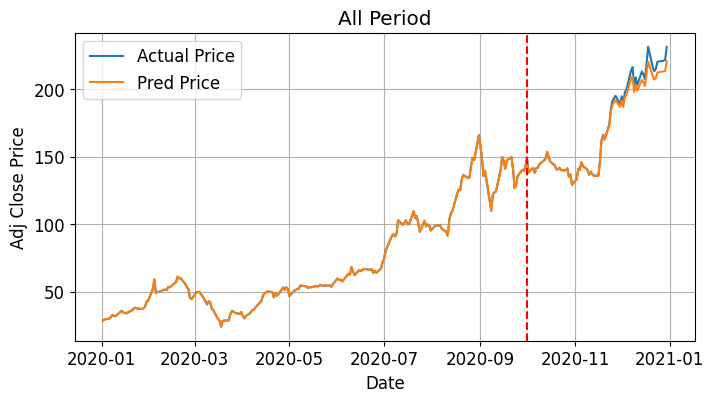

In [39]:
# plotting all period
period = 'All'
plt_graph(period, True)

In [40]:
period = 'Validation'
mse = calc_mse(y_true[n_split:], y_hat[n_split:])
print(f'MSE ({period}): {mse}')
# 14.8, 13, 1.47

MSE (Validation): 14.779055482534218
